# Laboratory Task 1: Predicting the number of publications 

---

## Modules import / Импортирование модулей

In [ ]:
# !pip install mlforecast

In [3]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import random

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
from mlforecast import MLForecast
from window_ops.rolling import rolling_mean

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf


import folium
from folium.plugins import MarkerCluster, HeatMap
import ipywidgets as widgets
from IPython.display import display, HTML

from tqdm import tqdm
from geopy.geocoders import Nominatim
from IPython.display import clear_output
import os
tqdm.pandas()

In [4]:
train_data = pd.read_csv('train_data.csv')
val = pd.read_csv('validation_data_new.csv') 

In [5]:
test_data = pd.read_csv("test.csv")

---

## Explorational Data Analysis and Data Preparation 

In [6]:
train_data.head()

,timestamp,lon,lat,likescount,commentscount,symbols_cnt,words_cnt,hashtags_cnt,mentions_cnt,links_cnt,emoji_cnt,point
0,1565607600,30.329370,59.940488,63,4,52,6,0,0,0,0,0101000020E6100000DBC1F19351543E4006FC5DE561F8...
1,1565568000,30.342845,59.869542,44,0,40,0,4,0,0,0,0101000020E6100000544263A8C4573E40C27FCF284DEF...
2,1565568000,30.322632,60.039332,30,0,77,7,0,0,0,1,0101000020E61000009E01B90998523E40888919D70805...
3,1565568000,30.322632,59.938238,13,0,634,17,32,0,0,7,0101000020E61000009E01B90998523E40CEB8CE2B18F8...
4,1565568000,30.309158,59.932612,8,0,0,0,0,0,0,0,0101000020E6100000268147F5244F3E40494A4ED65FF7...


It is known that in the test dataset the coordinates are located in a square with coordinates of opposite corners (60.039332, 30.515771), (59.831191, 30.142969). Let's get rid of those training data that fall outside the boundaries of this square.

Известно, что в тестовом датасете координаты расположены в квадрате с координатами противоположных углов (60.039332, 30.515771), (59.831191, 30.142969). Избавимся от тех тренировочных данных, которые выходят за границы этого квадрата. 

In [7]:
# границы
min_lon = 30.142969
max_lon = 30.5360
min_lat = 59.828
max_lat = 60.0393322852

filtered_df = train_data[
    (train_data['lon'] >= min_lon) &
    (train_data['lon'] <= max_lon) &
    (train_data['lat'] >= min_lat) &
    (train_data['lat'] <= max_lat)
]

---

The data is to be divided into polygons. It is known that **lon** and **lat** are written rounded to a polygon of 250x250 metres. Hence, a unique pair of these values corresponds to information about one polygon. Let's perform grouping by latitude and longitude to find out the number of polygons. At the same time we will estimate the number of records per one polygon.

Данные необходимо разбить на полигоны. Известно, что **lon** и **lat** записаны с округлением до полигона 250х250 метров. Значит уникальная пара этих значений соответствует информации об одном полигоне. Произведем группировку по широте и долготе, чтобы узнать число полигонов. Заодно оценим число записей на один полигон. 

In [8]:
polygons = (
    filtered_df.groupby(["point"])
    .size()
    .reset_index(name='count')
    .sort_values(by=["count"], ascending=False)
)
polygons

,point,count
2702,0101000020E6100000669634C7914E3E407AB3D8B484F7...,196054
5223,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,145191
4314,0101000020E6100000A4566D514B503E40A554BF083DF8...,120424
1105,0101000020E610000029D6FB3CD84C3E408F0FCDBE88F9...,118465
2571,0101000020E61000006141807FDE503E402B348A98ADF9...,115011
...,...,...
6022,0101000020E6100000E030027AF0733E40586790FFD8EC...,1
3550,0101000020E61000008A3ED7042C3C3E40FC619B9199F0...,1
3544,0101000020E61000008A3ED7042C3C3E40EC94646534F4...,1
1392,0101000020E610000036D51814F2453E4031CCB7976EFF...,1


In [9]:
polygons['count'].describe()

count      6804.000000
mean       1232.962081
std        5922.631033
min           1.000000
25%          17.000000
50%          86.000000
75%         414.250000
max      196054.000000
Name: count, dtype: float64

We can see a wide variation in the number of records per polygon, from 1 to almost 200_000. The mean value is 1233 records per polygon, while the median value is only 86. This indicates a serious imbalance between the amount of data for individual regions and will affect the quality of prediction in regions where there is little data.

Виден широкий разброс по числу записей на один полигон - от 1 до почти 200_000. Среднее значение 1233 записей на полигон, при этом медианное - лишь 86. Это говорит о серьезном дисбалансе между количеством данных для отдельных регионов и повлияет на качество предсказания в тех регионах, где данных мало. 

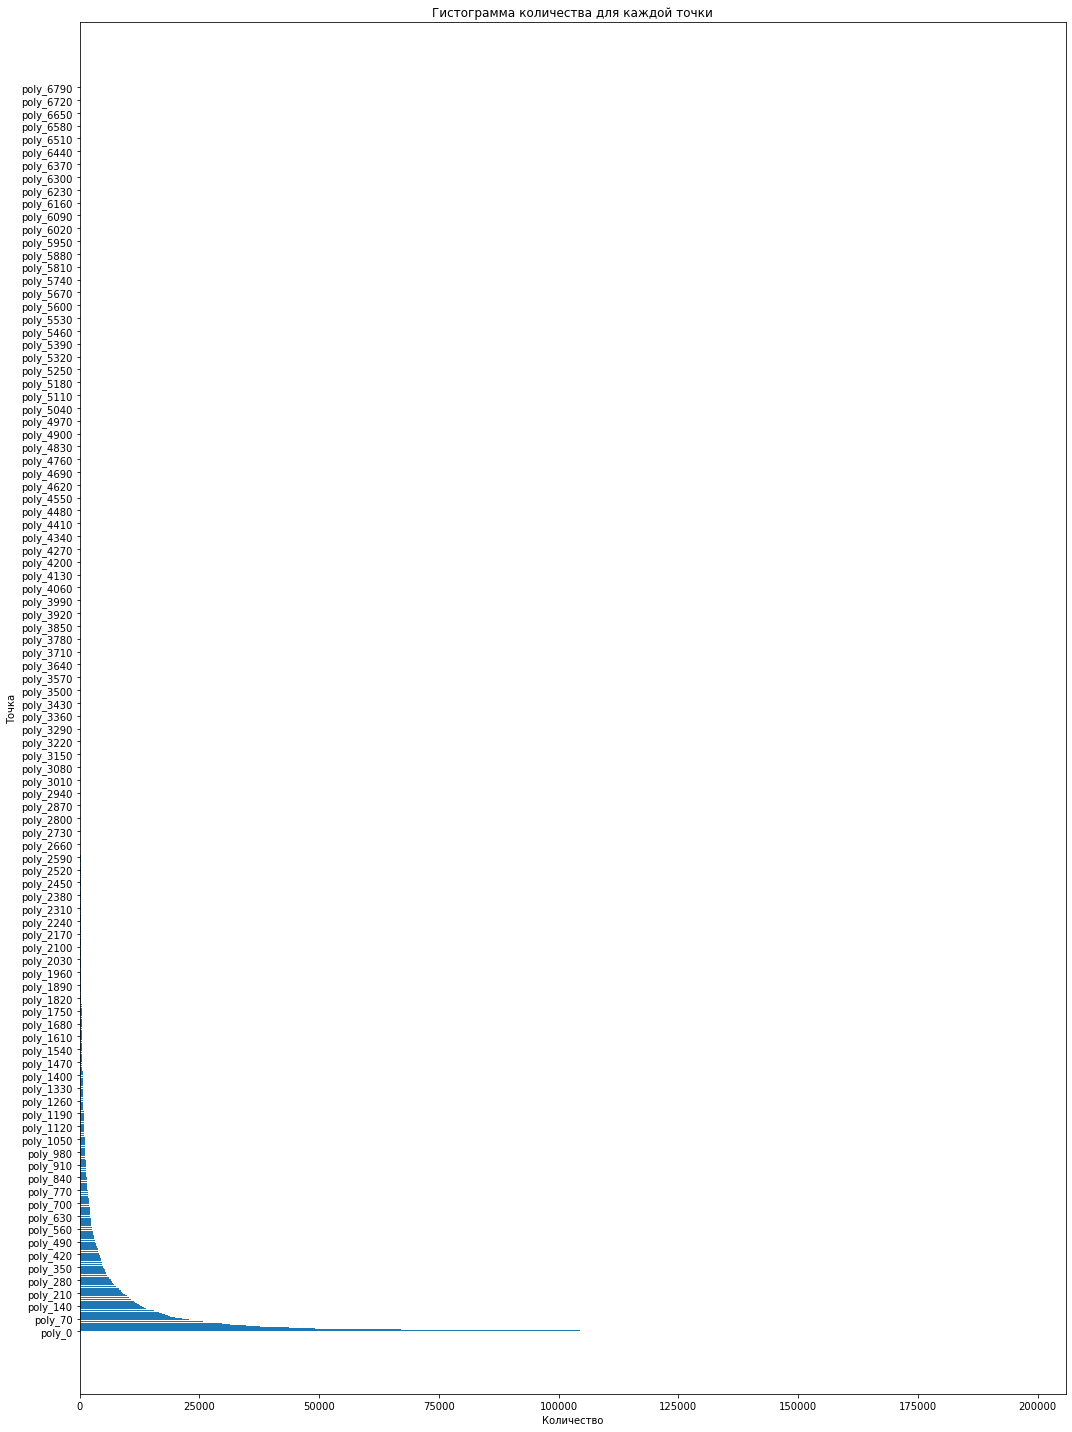

In [10]:
shortened_labels = [f"poly_{i}" for i in range(len(polygons["point"]))]

plt.figure(figsize=(15, 20))
plt.barh(shortened_labels, polygons["count"])

interval = 70
plt.yticks(range(0, len(shortened_labels), interval), shortened_labels[::interval])

plt.xlabel("Количество")
plt.ylabel("Точка")
plt.title("Гистограмма количества для каждой точки")

plt.tight_layout()
plt.show()

По графике более отчетливо видно, что действительно у нас сильный разброс, только в некоторых полигонах происходят действия от пользователей

---

The goal is to predict the number of publications per hour in each polygon. The current dataset characterises individual publications, which means that to obtain training data it is necessary to group the table by polygons and time. It is also worth noting that the metadata of publications (number of comments, likes, etc.) will not be used in predicting the number of posts, so it can be removed from the table.

Цель - предсказать количество публикаций в час в каждом полигоне. Текущий набор данных характеризует отдельные публикации, значит, для получения обучающих данных необходимо сгруппировать таблицу по полигонам и времени. Также стоит отметить, что метадата публикаций (число комментариев, лайков и т.д.) не будет использоваться при предсказании числа постов, а значит ее можно удалить из таблицы.

In [11]:
filtered_df = filtered_df.drop(
    columns=[
        "likescount",
        "commentscount",
        "symbols_cnt",
        "words_cnt",
        "hashtags_cnt",
        "mentions_cnt",
        "links_cnt",
        "emoji_cnt",
    ]
)

In [12]:
train_transformed = filtered_df.groupby(['point', 'lon', 'lat', 'timestamp']).size().reset_index(name='num_publications')

In [13]:
train_transformed.sample(5)

,point,lon,lat,timestamp,num_publications
1994409,0101000020E610000091029C327E593E40A08C1570AEEA...,30.349582,59.833448,1562356800,1
2128716,0101000020E61000009BAC04C2E4543E402D3C4E79D0F8...,30.331616,59.943862,1565290800,4
1844522,0101000020E61000008A5833A3175E3E408A3E86115104...,30.367548,60.033724,1551196800,7
1848101,0101000020E61000008A5833A3175E3E408A3E86115104...,30.367548,60.033724,1571605200,2
3037765,0101000020E6100000D752E1ADB2343E405009D46AD3EA...,30.205851,59.834577,1547650800,1


---

When working with time series, date and time divided into years, months, days, hours, etc. should be used as a feature. Let's transform the **timestamp** column into several feature columns.

При работе с time series в качестве фичей следует использовать дату и время в разделенном на года, месяцы, дни, часы и т.д. виде. Произведем трансформацию столбца **timestamp** в несколько столбцов признаков.

In [14]:
train_transformed['datetime'] = pd.to_datetime(train_transformed['timestamp'], unit='s')
train_transformed['day'] = train_transformed['datetime'].dt.day
train_transformed['month'] = train_transformed['datetime'].dt.month
train_transformed['year'] = train_transformed['datetime'].dt.year
train_transformed['hour'] = train_transformed['datetime'].dt.hour

In [15]:
train_transformed.head()

,point,lon,lat,timestamp,num_publications,datetime,day,month,year,hour
0,0101000020E610000002BF48199F3F3E400A41C338F1F6...,30.248521,59.929237,1546358400,1,2019-01-01 16:00:00,1,1,2019,16
1,0101000020E610000002BF48199F3F3E400A41C338F1F6...,30.248521,59.929237,1546430400,1,2019-01-02 12:00:00,2,1,2019,12
2,0101000020E610000002BF48199F3F3E400A41C338F1F6...,30.248521,59.929237,1546434000,1,2019-01-02 13:00:00,2,1,2019,13
3,0101000020E610000002BF48199F3F3E400A41C338F1F6...,30.248521,59.929237,1546963200,1,2019-01-08 16:00:00,8,1,2019,16
4,0101000020E610000002BF48199F3F3E400A41C338F1F6...,30.248521,59.929237,1547290800,1,2019-01-12 11:00:00,12,1,2019,11


In [16]:
# Функция для создания и отображения интерактивной карты с тепловой картой и границами
def create_heatmap_with_boundaries(year, month, day, hour):
    # Фильтрация данных по выбранному часу
    temp_df = train_transformed[train_transformed['hour'] == hour]
    temp_df = temp_df[temp_df['month'] == month]
    temp_df = temp_df[temp_df['year'] == year]
    temp_df = temp_df[temp_df['day'] == day]
    
    # Создание карты
    m = folium.Map(location=[train_transformed['lat'].mean(), train_transformed['lon'].mean()], zoom_start=10.5)
    marker_cluster = MarkerCluster()
    
        # Добавление маркеров на карту
    for index, row in temp_df.iterrows():
        marker_cluster.add_child(folium.Marker([row['lat'], row['lon']]))
    
    # Преобразование данных в формат, подходящий для создания тепловой карты
    heatmap_data = [[row['lat'], row['lon'], row['num_publications']] for _, row in temp_df.iterrows()]
    
    # Создание тепловой карты
    heatmap = HeatMap(heatmap_data)
    heatmap.add_to(m)
    
    # Координаты границ
    min_lon = 30.142969
    max_lon = 30.5360
    min_lat = 59.828
    max_lat = 60.0393322852

    # Создание объекта PolyLine для границ
    boundary_coordinates = [[min_lat, min_lon], [max_lat, min_lon], [max_lat, max_lon], [min_lat, max_lon], [min_lat, min_lon]]
    boundary_line = folium.PolyLine(locations=boundary_coordinates, color='red')

    # Добавление объекта PolyLine на карту
    boundary_line.add_to(m)
    m.add_child(marker_cluster)
    
    # Отображение карты
    display(m)

# Создание ползунка для выбора времени
year_slider = widgets.IntSlider(min=train_transformed['year'].min(), max=train_transformed['year'].max(), step=1, value=train_transformed['year'].min())
month_slider = widgets.IntSlider(min=train_transformed['month'].min(), max=train_transformed['month'].max(), step=1, value=train_transformed['month'].min())
day_slider = widgets.IntSlider(min=train_transformed['day'].min(), max=train_transformed['day'].max(), step=1, value=train_transformed['day'].min())
hour_slider = widgets.IntSlider(min=train_transformed['hour'].min(), max=train_transformed['hour'].max(), step=1, value=train_transformed['hour'].min())

# Создание интерактивной карты с тепловой картой и границами
widgets.interactive(create_heatmap_with_boundaries, year=year_slider, month=month_slider, day=day_slider, hour=hour_slider)


interactive(children=(IntSlider(value=2019, description='year', max=2020, min=2019), IntSlider(value=1, descri…

Рассматривая карту, можно легко заметить, что основная активность пользователей сосредотачивается в центре города. Поэтому мы хотим учесть местоположение, такие как округ и улицу, как дополнительные факторы, влияющие на частоту событий.

Кроме того, важно отметить, что существует множество полигонов, в которых совершаются очень мало или вообще нет событий, и, следовательно, значения в этих местах будут равны нулю. В будущем мы можем рассмотреть оптимизацию процессов обучения и возможность изменения размера полигонов или выбора районов более тщательно.

Ниже мы также проанализируем самые популярные районы, что поможет модели более точно предсказывать результаты.

In [17]:
geolocator = Nominatim(user_agent="my_app")
def fill_dataframe(row):
    latitude = row['lat']
    longitude = row['lon']
    location = geolocator.reverse(str(latitude)+","+str(longitude), timeout=4)
    address = location.raw['address']
    row['address'] = address.get('road')
    row['district'] = address.get('city_district')
    return row

In [18]:
for_parsing = train_transformed.groupby(["point", "lon", "lat"]).size().reset_index(name='count')

In [19]:
geo_data_file = 'geo_data.csv'

if os.path.isfile(geo_data_file):
    data_for_ml = pd.read_csv(geo_data_file)
    print(f"Данные успешно загружены из : {geo_data_file}")
    
else:
    print(f"Файла {geo_data_file} не существует. Начинаю парсинг данных: ")
    data_for_ml = for_parsing.progress_apply(fill_dataframe, axis=1)
    clear_output(True)
    data_for_ml.to_csv(geo_data_file, index=False)
    print("Данные успешно получены!!!")


Данные успешно загружены из : geo_data.csv


In [20]:
data_for_ml.sample(5)

,point,lon,lat,count,address,district
4206,0101000020E61000009E01B90998523E40EC94646534F4...,30.322632,59.907849,2,Заозёрная улица,NaN
3464,0101000020E610000084E922BD783E3E4091618BDE42FB...,30.244030,59.962978,622,Петровская коса,Петровский округ
3334,0101000020E610000080946E75C5403E40E894CF02E001...,30.253013,60.014649,72,Комендантский проспект,округ Озеро Долгое
2127,0101000020E610000050EDAE60115A3E404822740997EF...,30.351828,59.871797,2,NaN,округ Гагаринское
4929,0101000020E6100000BE54A7FF7E423E402D3C4E79D0F8...,30.259750,59.943862,216,17-я линия В.О.,Васильевский округ


In [21]:
data_for_ml = data_for_ml.fillna('unknown')

Там, где получились None, либо деревня, либо окрайна 

In [22]:
columns_to_drop = ['lon', 'lat', 'count']
data_for_ml = data_for_ml.drop(columns=columns_to_drop)

In [23]:
final_df = train_transformed.merge(data_for_ml, on='point', how='inner')

In [24]:
final_df = final_df.sort_values(by='datetime')
final_df.head()

,point,lon,lat,timestamp,num_publications,datetime,day,month,year,hour,address,district
1175089,0101000020E6100000544263A8C4573E408991431816F7...,30.342845,59.930362,1546300800,1,2019-01-01,1,1,2019,0,Графский переулок,Владимирский округ
633865,0101000020E61000002D1154E69F283E4076150862DBFE...,30.158690,59.991070,1546300800,5,2019-01-01,1,1,2019,0,Лахтинский проспект,округ Лахта-Ольгино
3002843,0101000020E6100000D2178904EB583E40E4A1F770CEF7...,30.347336,59.935988,1546300800,1,2019-01-01,1,1,2019,0,Литейный проспект,Литейный округ
448087,0101000020E6100000202C93AD71513E40CEB8CE2B18F8...,30.318141,59.938238,1546300800,9,2019-01-01,1,1,2019,0,Дворцовая площадь,Дворцовый округ
119333,0101000020E61000000C830D47F15C3E407916A554F5F8...,30.363057,59.944987,1546300800,1,2019-01-01,1,1,2019,0,Фурштатская улица,округ Смольнинское


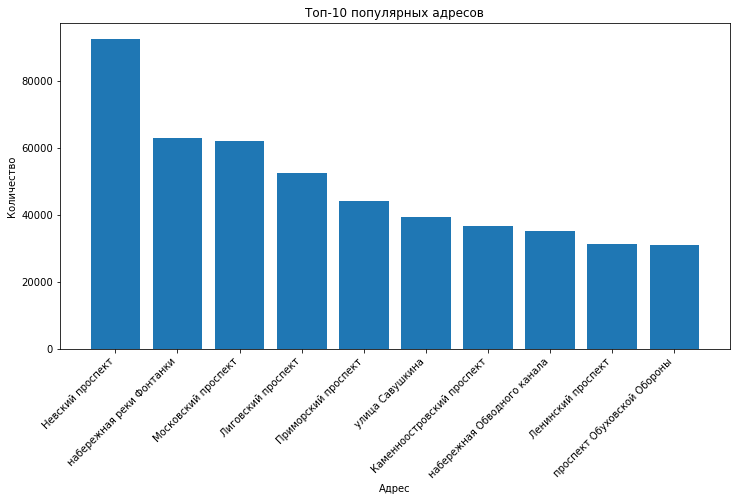

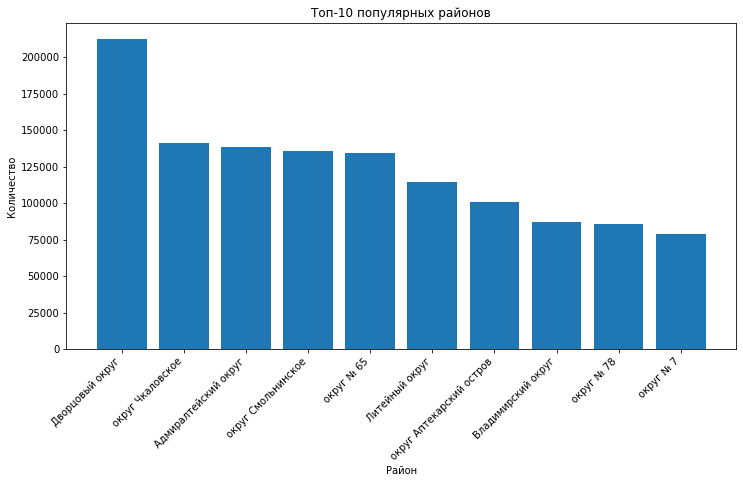

In [25]:
df_adress = final_df[final_df['address'] != 'unknown']
df_district = final_df[final_df['district'] != 'unknown']

top_addresses = df_adress['address'].value_counts().head(10)
top_districts = df_district['district'].value_counts().head(10)

plt.figure(figsize=(12, 6))
plt.bar(top_addresses.index, top_addresses.values)
plt.title('Топ-10 популярных адресов')
plt.xlabel('Адрес')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right') 
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(top_districts.index, top_districts.values)
plt.title('Топ-10 популярных районов')
plt.xlabel('Район')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.show()


Из анализа выделяются следующие популярные адреса:

- Невский проспект
- Набережная реки Фонтанки
- Московский проспект
- Лиговский проспект
- Приморский проспект
- Улица Савушкина
- Каменноостроительный проспект
- Набережная Обводного канала
- Ленинский проспект
- Проспект Обуховской обороны

Кроме того, среди популярных районов можно выделить:

- Дворцовый округ
- Округ Чкаловское
- Адмиралтейский округ
- Смольнинское округ
- Округ №65
- Литейный округ
- Округ Аптекарский остров
- Владимирский округ
- Округ №78
- Округ №7

Этот анализ позволяет сделать вывод о том, что наибольшая активность пользователей наблюдается в центре города и его близлежащих районах. Такие улицы, как Невский проспект и Московский проспект, а также районы, включая Дворцовый округ и Адмиралтейский округ, привлекают наибольшее количество событий. Это важная информация для оптимизации процессов обучения модели и выбора более релевантных районов для анализа.

## Seasonality research 

Let's study seasonality for the top 5 polygons with the highest number of publications.

Изучим сезонность для 5 полигонов с самым большим числом публикаций.

In [26]:
top5 = (
    train_transformed.groupby("point")
    .size()
    .reset_index(name="count")
    .sort_values(by="count", ascending=False)
    .head(5)
) # Select 5 polygons with the biggest number of publications

In [27]:
polygon_list = [
    train_transformed[train_transformed["point"] == top5.iloc[i, 0]]
    .sort_values(by="datetime")
    .set_index("datetime")
    for i in range(5)
] # Select the data of the required polygons

In [28]:
daily_decomposed_list = [
    seasonal_decompose(
        polygon.num_publications
        .resample("1D")
        .sum()
    )
    for polygon in polygon_list
] # Create 1 day seasonal decompose for the chosen polygons

In [29]:
hourly_decomposed_list = [
    seasonal_decompose(
        polygon.num_publications["2019-06-09 00:00":"2019-06-16 00:00"]
        .resample("1H")
        .sum()
    )
    for polygon in polygon_list
] # Create 1 hour seasonal decompose for the chosen polygons

---

### Trend / Тренд

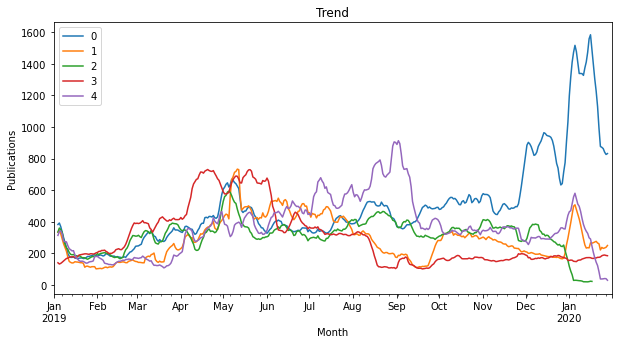

In [30]:
for decomposed in daily_decomposed_list:
    decomposed.trend.plot(ax=plt.gca(), figsize=(10, 5))
plt.title("Trend")
plt.ylabel("Publications")
plt.xlabel("Month")
plt.legend(range(5), loc='upper left')
plt.show()

In the dataset under study, the trends of the polygons are different. For example, the graph shows that the blue polygon tends to increase the number of publications, while the red polygon is rather characterised by a decline.

В исследуемом датасете тренды полигонов различны. К примеру, на графике видно что синий полигон имеет тренд на увеличение числа публикаций, в то время как красный скорее характеризуется спадом.

---

### Monthly seasonality / Помесячная сезонность

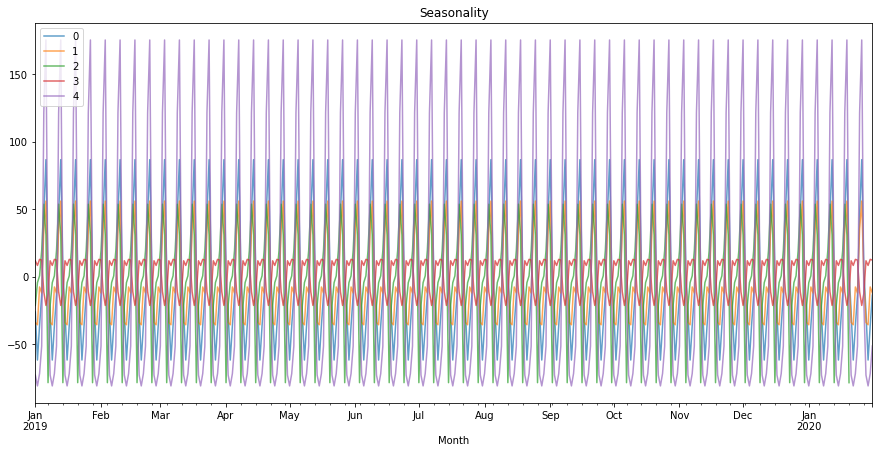

In [31]:
for decomposed in daily_decomposed_list:
    decomposed.seasonal.plot(ax=plt.gca(), figsize=(15, 7), alpha=0.7)
plt.title("Seasonality")
plt.xlabel("Month")
plt.legend(range(5), loc='upper left')
plt.show()

At the same time, the presence of weekly seasonality, which is characteristic of all 5 selected polygons, can be traced.

В то же время, прослеживается наличие понедельной сезонности, которой характеризуются все 5 отобраных полигонов.

---

### June 2019 seasonality / Сезонность июня 2019

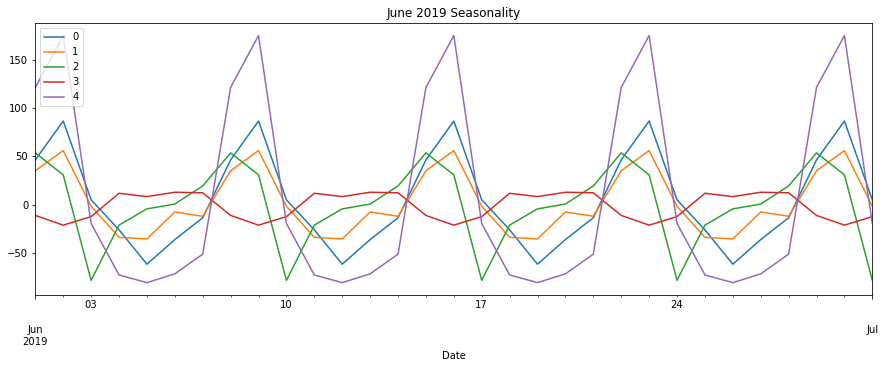

In [32]:
for decomposed in daily_decomposed_list:
    decomposed.seasonal["2019-06-01":"2019-07-01"].plot(ax=plt.gca(), figsize=(15, 5))
plt.title("June 2019 Seasonality")
plt.xlabel("Date")
plt.legend(range(5), loc='upper left')
plt.show()

A closer look at the monthly seasonality shows that there are also possible differences between polygons here. For example, in the graph above we see seasonal increases in the number of publications on weekends for the green polygon. The red polygon does not have an obvious peak, but is characterised by seasonal sags in the number of weekend publications. The purple, blue and orange polygons have peaks on Mondays, although there is a noticeable increase on weekends.

При более подробном рассмотрении месячной сезонности видно, что здесь между полигонами также возможны различия. К примеру, на графике выше мы видим сезонные увеличения числа публикаций на выходных для зеленого полигона. Красный полигон не имеет явно выраженного пика, однако характеризуется сезонными просадками числа публикаций по выходным. Фиолетовый, синий и оранжевый полигоны имеют пики по понедельникам, хотя ощутимый рост приходится на выходные. 



---

### June 9-16 week seasonality / Сезонность недели 9-16 июня 2019

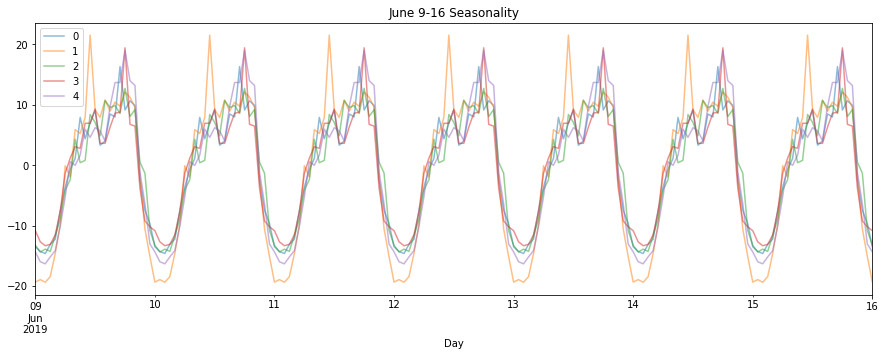

In [33]:
for day_decomposed in hourly_decomposed_list:
    day_decomposed.seasonal.plot(ax=plt.gca(), figsize=(15, 5), alpha=0.5)
plt.title("June 9-16 Seasonality")
plt.xlabel("Day")
plt.legend(range(5), loc='upper left')
plt.show()

When looking at seasonality within a single week, daily seasonality becomes apparent: there is less activity at night.

При рассмотрении сезонности в рамках одной недели становится заметна ежедневная сезонность: по ночам активность снижется.

---


### June 9 2019 seasonality / Сезонность 9 июня 2019

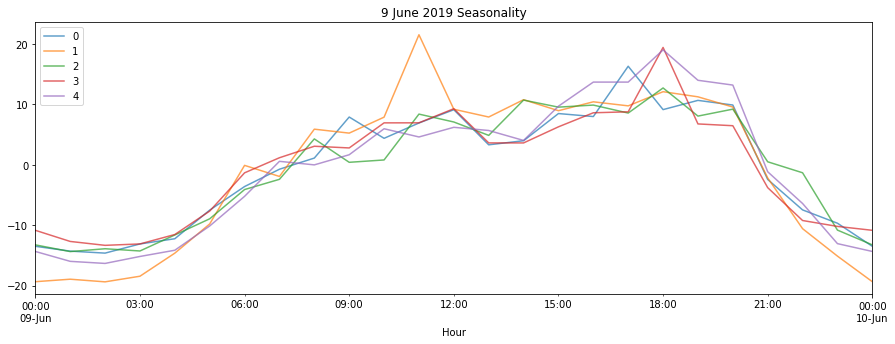

In [34]:
for day_decomposed in hourly_decomposed_list:
    day_decomposed.seasonal["2019-06-09 00:00":"2019-06-10 00:00"].plot(
        ax=plt.gca(), figsize=(15, 5), alpha=0.7
    )
plt.title("9 June 2019 Seasonality")
plt.xlabel("Hour")
plt.legend(range(5), loc="upper left")
plt.show()

Finally, looking at seasonality within a single day provides insight into the fact that an increase in activity begins around 5am and declines after 8pm.

И, наконец, рассмотрение сезонности в рамках одного дня дает понимание, что рост активности начинается примерно в 5 часов утра, а спад после 8 часов вечера.

---

### Average number of publications research / Исследование среднего числа публикаций

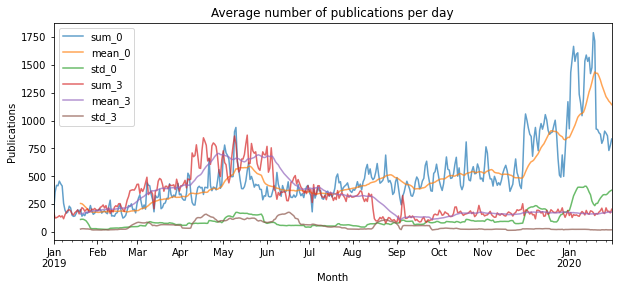

In [35]:
for i in [0, 3]:
    polygon_list[i].num_publications.resample("1D").sum().plot(
        label=f"sum_{i}", legend=True, figsize=(10, 4), alpha=0.7
    )
    polygon_list[i].num_publications.resample("1D").sum().rolling(20).mean().plot(
        label=f"mean_{i}", legend=True, alpha=0.7
    )
    polygon_list[i].num_publications.resample("1D").sum().rolling(20).std().plot(
        label=f"std_{i}", legend=True, alpha=0.7
    )
plt.ylabel("Publications")
plt.xlabel("Month")
plt.title("Average number of publications per day");


The change in the mean over time, as well as the presence of seasonality in the previous subparagraphs, indicates the non-stationarity of the series.

Изменение среднего во времени, как и наличие сезонности в предыдущих подпунктах, говорит о нестационарности ряда. 

---

### Autocorrelation function / Функция автокорреляции

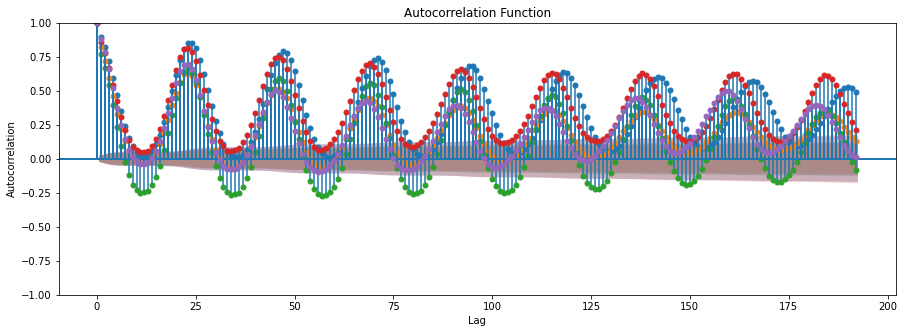

In [36]:
figure, ax = plt.subplots(figsize=(15, 5))
for polygon in polygon_list:
    plot_acf(ax=ax, x=polygon.num_publications, lags=192)

plt.title("Autocorrelation Function")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.show()

The autocorrelation graph once again shows the presence of seasonality in the data. In the graph above, the autocorrelation function is plotted relative to a lag of 8 days (192 hours), i.e. it covers one whole week. As can be seen from the graph, even after a week the correlation between the values is very significant (more than 0.5).


График автокорреляции в очередной раз показывает наличие сезонности в данных. На графике выше автокорреляционная функция построена относительно лага в 8 дней (192 часа), т.е захватывает одну целую неделю. Как видно из графика, даже спустя неделю корреляция между значениями весьма значительна (более 0.5). 

---

### Сonclusion / Вывод

The above graphs show the presence of daily and weekly seasonality. At the same time, no general dependencies on month or time of year were found. Consequently, for successful prediction for 4 weeks (28 days) the model should be given features that will reflect the found seasonalities for a distance of approximately one month. Such signs can be: shifts (lags) for a given number of hours and moving average values for the specified periods.

Построенные выше графики показывает наличие дневной и недельной сезонностей. В то же время, общих зависимостей от месяца или времени года не выявлено. Следовательно, для удачного предсказания на 4 недели (28 дней) модели следует передать признаки, который будут отражать найденные сезонности на расстоянии приблизительно одного месяца. Такими признаками могут быть: сдвиги (лаги) на заданное количество часов и значения скользящего среднего за указанные периоды.

---

## Preparing data for training / Подготовка данных для обучения

Let's create a set of functions that will:
* Decompose the **datetime** column into a separate attribute - year, month, day, hour;
* Create attributes by shift and moving average;
* Get attributes of the required polygon, complete the dataframe to the full sequence from the minimum date to the maximum one (i.e. create rows of those segments where the number of publications is equal to zero) and create additional attributes specified earlier;
* Error calculation function.

It is also necessary to preprocess the validation dataset so that it has the same format and the same fields as the training data.

Создадим набор функций, которые будут:
* Раскладывать столбец **datetime** на отдельный признаки - год, месяц, день, час;
* Создавать признаки сдвигом и скользящим средним;
* Доставать признаки требуемого полигона, доформировывать датафрейм до полной последовательности от минимальной даты к максимальной (т.е создавать строки тех отрезков, где число публикаций равно нулю) и создавать указанные ранее дополнительные признаки;
* Функцию расчета ошибки.

Также необходимо произвести предобработку валидационного датасета, чтобы он имел тот же формат и те же поля, что и обучающие данные. 

In [37]:
def make_datetime_features(df: pd.DataFrame):
    """
    Create separate year, month, day and hour features
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['hour'] = df.index.hour

In [38]:
def make_features(df: pd.DataFrame, max_lag: int, rolling_mean_size: [int, list]):
    """
    Generate features of two types: lag features and rolling mean features
    """
    for lag in range(1, max_lag + 1):
        df[f"lag_{lag}"] = df["num_publications"].shift(lag)

    for size in rolling_mean_size:
        df[f"rolling_mean_{size}"] = (
            df["num_publications"].shift().rolling(size).mean()
        )

In [39]:
def pick_polygon_data(data: pd.DataFrame, point: str):
    """
    Pick data of the chosen polygon by point
    """
    polygon = data[data.point == point].set_index('datetime') # 
    
    new_index = pd.date_range(start=data.datetime.min(), end=data.datetime.max(), freq='H')
    polygon = polygon.reindex(new_index) # Create rows of missing datetimes

    make_datetime_features(polygon) # Create datetime features

    timestamp_array = polygon.index.floor('H').astype(np.int64) // 10**9 # Create timestamp array with rounding to 1 hour
    polygon.timestamp = timestamp_array # Fill timestamp field

    polygon.lon = polygon.lon.max() # Copy longitude to all rows
    polygon.lat = polygon.lat.max() # Copy latitude to all rows
    polygon.point = polygon[polygon.notna()].point.iloc[0] # Copy point code to all rows
    polygon.num_publications = polygon.num_publications.fillna(0) # Fill "blank" hours with zero publications

    make_features(polygon, 72, [24, 72, 168]) # 72h (3d) lags and 24h, 72h, 168h (1d, 3d, 7d) rolling means 

    polygon = polygon.fillna(0) # fill NA's generated by lag and rolling means

    return polygon

In [40]:
def calculate_error(ground_truth, predictions):
    error_value = abs(abs(predictions - ground_truth)/predictions) # Double abs() because predictions may be negative
    return error_value

In [41]:
val_transformed = val.rename(columns={'sum':'num_publications', 'hour':'timestamp'})
val_transformed['datetime'] = pd.to_datetime(val_transformed['timestamp'], unit='s')

In [42]:
test_transformed = test_data.rename(columns={'sum':'num_publications', 'hour':'timestamp'})
test_transformed['datetime'] = pd.to_datetime(test_transformed['timestamp'], unit='s')

---

## Model training / Обучение модели

Linear regression is chosen as the machine learning algorithm because of its good speed and good quality of predictions on time series. 

The following learning principle will be applied:
1. Selecting data for the polygon according to the unique value of the **point** service field;
2. training the linear regression model on the obtained data;
3. Validation of the model;
4. Recording the validation result and the model itself into dictionaries, from which it will be possible to retrieve the object by the key, which is the value of the **point** service field.



В качестве алгоритма машинного обучения выбрана линейная регрессия, поскольку она отличается хорошим быстродействием и неплохим качеством предсказаний на временных рядах. 

Будет применяться следующий принцип обучения:
1. Отбор данных для полигона согласно уникальному значению сервисного поля **point**;
2. Обучение модели линейной регрессии на полученных данных;
3. Валидация модели;
4. Запись результата валидации и самой модели в словари, из которых впоследствие можно будет получить объект по ключу, которым является значение сервисного поля **point**. 

In [ ]:
train_transformed = train_transformed.drop(columns=['day', 'year', 'month', 'hour'])

In [ ]:
val_regress = test_transformed.set_index('datetime')[['num_publications', 'error', 'point']]
val_regress['reg_preds'] = None
val_regress['reg_error'] = None
val_regress.head()

reg_errs = []
base_errs = []
num_pubs = []
reg_preds = []

for point in tqdm(test_transformed.point.unique()):
    polygon_train = pick_polygon_data(train_transformed, point) # Get polygon train data

    # Split the train data into features and targets
    X_train = polygon_train.drop(columns=['timestamp', 'point', 'lon', 'lat', 'num_publications'])
    y_train = polygon_train.num_publications   
    
    val_point = val_regress[val_regress.point == point]
    
    polygon_val = pick_polygon_data(test_transformed, point) # Get polygon val data

    # Split the val data into features and targets
    X_val = polygon_val.drop(columns=['num_publications', 'error', 'timestamp', 'point', 'lon', 'lat'])
    y_val = polygon_val.num_publications
    
    pipe = Pipeline([
        ('scaler', StandardScaler()), # Standardize features
        ('model', LinearRegression())
    ])

    pipe.fit(X_train, y_train)

    predictions = pd.Series(pipe.predict(X_val), index=y_val.index)
    predictions[predictions < 0] = 0.1

    predictions_selected = predictions.loc[val_point.index]
    metric = calculate_error(val_point.num_publications, predictions_selected)

    reg_errs += list(metric.values)
    base_errs += list(val_point.error.values)
    num_pubs += list(val_point.num_publications.values)
    reg_preds += list(predictions_selected.values)

In [ ]:
val_regress = val_transformed.set_index('datetime')[['num_publications', 'error', 'point']]
val_regress['reg_preds'] = None
val_regress['reg_error'] = None
val_regress.head()

In [ ]:
reg_errs = []
base_errs = []

num_pubs = []
reg_preds = []

for point in tqdm(val_transformed.point.unique()):
    polygon_train = pick_polygon_data(train_transformed, point) # Get polygon train data

    # Split the train data into features and targets
    X_train = polygon_train.drop(columns=['timestamp', 'point', 'lon', 'lat', 'num_publications'])
    y_train = polygon_train.num_publications   
    
    val_point = val_regress[val_regress.point == point]
    
    polygon_val = pick_polygon_data(val_transformed, point) # Get polygon val data

    # Split the val data into features and targets
    X_val = polygon_val.drop(columns=['num_publications', 'error', 'timestamp', 'point', 'lon', 'lat'])
    y_val = polygon_val.num_publications
    
    pipe = Pipeline([
        ('scaler', StandardScaler()), # Standardize features
        ('model', LinearRegression())
    ])

    pipe.fit(X_train, y_train)

    predictions = pd.Series(pipe.predict(X_val), index=y_val.index)
    predictions[predictions < 0] = 0.1

    predictions_selected = predictions.loc[val_point.index]
    metric = calculate_error(val_point.num_publications, predictions_selected)

    reg_errs += list(metric.values)
    base_errs += list(val_point.error.values)
    num_pubs += list(val_point.num_publications.values)
    reg_preds += list(predictions_selected.values)

In [ ]:
# 'preds', 'true_values', 'reg_error', 'base_error'
val_reg_assesed = pd.DataFrame({'preds': reg_preds, 'true_values': num_pubs, 'reg_error': reg_errs, 'base_error': base_errs})

In [ ]:
predictions_selected

In [ ]:
metric

In [ ]:
# model_dict = {}
# val_metric_dict = {} 
# for point in tqdm(train_transformed.point.unique()):
#     polygon_train = pick_polygon_data(train_transformed, point) # Get polygon train data

#     # Split the train data into features and targets
#     X_train = polygon_train.drop(columns=['timestamp', 'point', 'lon', 'lat', 'num_publications'])
#     y_train = polygon_train.num_publications   

#     polygon_val = pick_polygon_data(val_transformed, point) # Get polygon val data

#     # Split the val data into features and targets
#     X_val = polygon_val.drop(columns=['num_publications', 'error', 'timestamp', 'point', 'lon', 'lat'])
#     y_val = polygon_val.num_publications
    
#     pipe = Pipeline([
#         ('scaler', StandardScaler()), # Standardize features
#         ('model', LinearRegression())
#     ])

#     pipe.fit(X_train, y_train)

#     predictions = pd.Series(pipe.predict(X_val), index=y_val.index)
#     predictions[predictions < 0] = 0
# #     print(((predictions < 0) * 1).sum())

#     metric = calculate_error(y_val, predictions)

#     model_dict[point] = pipe
#     val_metric_dict[point] = metric

---

## Results of trained models / Результаты обученных моделей

Let's get a list of Series objects that record hourly metrics for each of the polygons.

Получим список объектов Series, в которых записаны почасовые метрики для каждого из полигонов.

In [ ]:
val_metric_series_list = list(val_metric_dict.values()) # Squeeze dictionary's values into list

In [ ]:
val_point_series_list = list(val_metric_dict.keys()) # Squeeze dictionary's keys into list

Now that we have this list, the following metrics can be evaluated:
1. The mean, median, minimum and maximum of the mean of the polygons
2. The mean, median, minimum and maximum across all polygons and hours

Теперь, когда у нас есть этот список, можно оценить следующие метрики:
1. Среднее, медиану, минимальное и максимальное из средних по полигонам
2. Среднее, медиану, минимальное и максимальное значение по всем полигонам и часам

---

### The mean, median, minimum and maximum of the mean of the polygons / Среднее, медиана, минимальное и максимальное из средних по полигонам

In [ ]:
val_reg_assesed.describe()

In [ ]:
val_reg_assesed.describe()

Видим, что как на валидационных так и на тестовых данных модель справляется не очень хорошо - средняя ошибка имеет значение 70 (при бейзлайне в 2.6)

In [ ]:
val_means_series = pd.Series(
    [val_metric_series.mean() for val_metric_series in val_metric_series_list],
    val_point_series_list,
)

In [ ]:
train_transformed.describe()

In [ ]:
val_means_series.describe()

In [ ]:
val['error'].describe() 

---

In [ ]:
val_full_metric_series = pd.concat(val_metric_series_list)

In [ ]:
pd.set_option('display.float_format', '{:.6f}'.format) # Fix exponential output of describe function
val_full_metric_series.describe()

## Final test / Финальное тестирование

In [ ]:
test = pd.read_csv('test_data.csv')

In [ ]:
test_transformed = test.rename(columns={'sum':'num_publications', 'hour':'timestamp'})
test_transformed['datetime'] = pd.to_datetime(test_transformed['timestamp'], unit='s')

In [ ]:
test_metric_dict = {}
for point in tqdm(train_transformed.point.unique()):
    polygon_test = pick_polygon_data(test_transformed, point)  # Get polygon train data

    # Split the test data into features and targets
    X_test = polygon_test.drop(
        columns=["num_publications", "error", "timestamp", "point", "lon", "lat"]
    )
    y_test = polygon_test.num_publications

    model = model_dict[point]

    predictions = pd.Series(model.predict(X_test), index=y_test.index)

    metric = calculate_error(y_test, predictions)

    test_metric_dict[point] = metric


In [ ]:
test_means_series = pd.Series(
    [val_metric_series.mean() for val_metric_series in val_metric_series_list],
    val_point_series_list,
)

In [ ]:
test_means_series.describe()

In [ ]:
test['error'].describe() 

---

### LightGBM

Для следующей модели, мы рассмотрим LightGBM, и используем библиотеку mlforecast для обучения наших данных как многомерного временного ряда. Мы хотим учесть какое-либо событие, даже если в определенное время на каком-то полигоне не происходило действий. 

Для достижения этой цели мы будем преобразовывать наши данные следующим образом:

1. Для каждого полигона мы создадим временные шаги, где будем отображать события. Даже если в определенное время не происходило событий, мы установим значение 0, чтобы сохранить информацию о том, что данные временные интервалы не были пропущены.

2. Дополнительно, в качестве признаков мы будем использовать информацию о времени, включая месяц, день, день недели, час и номер недели. Эти дополнительные признаки помогут модели учесть сезонность и зависимость от времени в данных.

Используя этот подход и библиотеку mlforecast, мы сможем обучить LightGBM на наших данных и учесть временные факторы для прогнозирования. Это позволит нам более точно предсказывать события на разных полигонах, даже если в какие-то моменты времени не происходило действий.

In [43]:
train_df = train_transformed[['point', 'datetime', 'num_publications']]
unique_polygons = train_df['point'].unique()
result_df = pd.DataFrame({'point': unique_polygons})

In [44]:
date_range = pd.date_range(start=train_df['datetime'].min(), end=train_df['datetime'].max(), freq='H')

In [45]:
unique_polygons = train_df['point'].unique()
result_df = pd.DataFrame({'point': np.repeat(unique_polygons, len(date_range))})
result_df['datetime'] = np.tile(date_range, len(unique_polygons))
result_df.sort_values(['point', 'datetime'], inplace=True)
result_df.reset_index(drop=True, inplace=True)

In [46]:
result_df.head()

,point,datetime
0,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 00:00:00
1,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 01:00:00
2,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 02:00:00
3,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 03:00:00
4,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 04:00:00


In [47]:
merged_train = result_df.merge(train_df, on=['point', 'datetime'], how='left')

In [48]:
merged_train['num_publications'].fillna(0, inplace=True)

In [49]:
merged_train.head()

,point,datetime,num_publications
0,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 00:00:00,0.0
1,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 01:00:00,0.0
2,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 02:00:00,0.0
3,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 03:00:00,0.0
4,0101000020E610000002BF48199F3F3E400A41C338F1F6...,2019-01-01 04:00:00,0.0


In [50]:
merged_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64665216 entries, 0 to 64665215
Data columns (total 3 columns):
 #   Column            Dtype         
---  ------            -----         
 0   point             object        
 1   datetime          datetime64[ns]
 2   num_publications  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.9+ GB


Для презентации

1. `freq='h'`: Частота данных устанавливается как 'час' (hourly), что означает, что модель будет прогнозировать на часовых интервалах.

2. `lags=[24 * i for i in range(1, 15)]`: Здесь определяются временные задержки (лаги), на которых модель будет обучаться. Это включает в себя лаги от 24 до 360 часов (от 1 часа до 2 недель) с шагом в 24 часа.

3. `lag_transforms`: Этот атрибут определяет, какие трансформации или преобразования данных должны быть применены к разным лагам. В данном случае, для лагов 24 и 48 часов выполняются две трансформации - rolling_mean с окнами 7 * 24 и 7 * 48. Rolling mean - это вычисление среднего значения для указанного окна времени, и эти трансформации позволяют модели учесть средние значения данных за разные временные периоды.

4. `num_threads=available_threads`: Здесь устанавливается количество потоков, которые могут использоваться для обработки данных и обучения модели.

5. `date_features`: Этот атрибут определяет, какие признаки, связанные с датой и временем, будут использованы при обучении модели. Эти признаки включают месяц, день, день недели, час и номер недели.

Эта настройка и создание модели позволяют модели учесть временные зависимости и осуществлять прогнозирование числа публикаций в час для разных полигонов с учетом лагов, трансформаций и дополнительных временных признаков.


In [51]:
available_threads = os.cpu_count() // 2

In [52]:
lgb_params = {
    'n_estimators': 200,
    'learning_rate': 0.05,    
    'verbose': -1,
    'num_leaves': 2700,
    'lambda_l1': 0.03,
    'lambda_l2': 0.5,
    'bagging_fraction': 0.9,
    'feature_fraction': 0.8,
    'random_state':42
}
hourly_fcst = MLForecast(
    models=lgb.LGBMRegressor(**lgb_params),
    freq='h',
    lags=[24 * i for i in range(1, 15)],
    lag_transforms={
        24: [(rolling_mean, 7 * 24)],
        48: [(rolling_mean, 7 * 24)],
    },
    num_threads=available_threads,
    date_features=['month', 'day', 'dayofweek', 'hour', 'week'], 
)
hourly_fcst.fit(
    merged_train,
    id_col='point',
    time_col='datetime',
    target_col='num_publications',
)

MLForecast(models=[LGBMRegressor], freq=<Hour>, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168', 'lag192', 'lag216', 'lag240', 'lag264', 'lag288', 'lag312', 'lag336', 'rolling_mean_lag24_window_size168', 'rolling_mean_lag48_window_size168'], date_features=['month', 'day', 'dayofweek', 'hour', 'week'], num_threads=8)

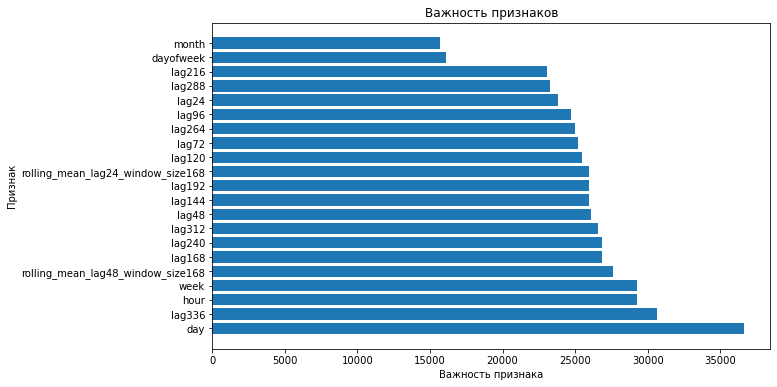

In [53]:
feature_importances = hourly_fcst.models_['LGBMRegressor'].feature_importances_
feature_names = hourly_fcst.ts.features_order_ 

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков')
plt.show()


In [54]:
predict = hourly_fcst.predict(24 * 29)

In [55]:
final_val = val_transformed.merge(predict, on=['point', 'datetime'], how='left')

In [56]:
final_val['my_error'] = abs(final_val['LGBMRegressor'] - final_val['num_publications']) / final_val['LGBMRegressor']

In [57]:
final_val.head()

,timestamp,lat,lon,point,num_publications,error,datetime,LGBMRegressor,my_error
0,1582448400,59.926986,30.318141,0101000020E6100000202C93AD71513E4070B5CC78A7F6...,5,0.421402,2020-02-23 09:00:00,4.958437,0.008382
1,1582225200,59.924735,30.241784,0101000020E6100000C5FE0F8FE53D3E4033438EB75DF6...,14,0.310291,2020-02-20 19:00:00,2.705640,4.174377
2,1581260400,60.002300,30.295683,0101000020E6100000AB00D6E0B14B3E40CB88A75E4B00...,5,3.754735,2020-02-09 15:00:00,5.001735,0.000347
3,1581958800,59.935988,30.324878,0101000020E61000005DECCB372B533E40E4A1F770CEF7...,7,0.504735,2020-02-17 17:00:00,5.235178,0.337108
4,1582779600,59.933737,30.306912,0101000020E6100000669634C7914E3E407AB3D8B484F7...,14,1.554735,2020-02-27 05:00:00,32.896230,0.574419


In [58]:
final_val.describe()

,timestamp,lat,lon,num_publications,error,LGBMRegressor,my_error
count,6.860000e+02,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,1.581783e+09,59.933357,30.327609,9.848397,2.644801,8.046036,1.110719
std,7.202487e+05,0.041569,0.068056,6.471299,3.868670,7.233600,3.014101
min,1.580548e+09,59.828934,30.142969,5.000000,0.003861,0.278646,0.000347
25%,1.581175e+09,59.921359,30.297929,6.000000,0.467870,3.455900,0.189483
50%,1.581799e+09,59.932612,30.322632,7.000000,1.408210,5.277737,0.406866
75%,1.582408e+09,59.949486,30.356319,11.000000,3.754735,10.338065,0.998191
max,1.583014e+09,60.039332,30.535982,40.000000,38.754735,43.611885,59.943376


Как показывают результаты, средняя ошибка модели составила 1.09, что существенно ниже, чем у начальной модели (baseline). Это говорит о том, что новая модель значительно улучшила свою способность предсказания. В частности, модель совершает гораздо меньше ошибок, особенно в ситуациях, где ошибка ранее была наибольшей.

Это означает, что мы создали более точную модель, которая более успешно предсказывает результаты и делает это с меньшей погрешностью.

In [59]:
def plot_random_time_series(df, predict):
    unique_points = df['point'].unique()
    
    random_points = random.sample(list(unique_points), 4)
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    for i, point in enumerate(random_points):
        subset = predict[predict['point'] == point]
        
        axes[i // 2, i % 2].plot(subset['datetime'], subset['LGBMRegressor'])
        axes[i // 2, i % 2].set_title(f'Point {point}')
        axes[i // 2, i % 2].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

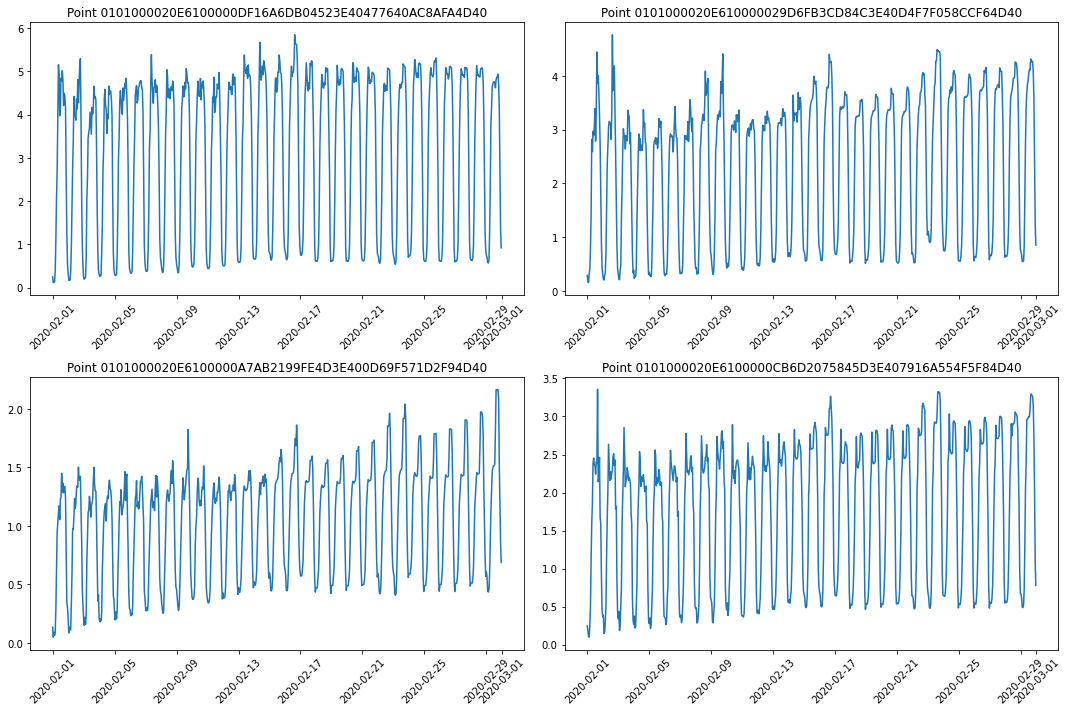

In [60]:
plot_random_time_series(df=final_val,
                        predict=predict)

In [ ]:
predict.to_csv('predict_without_address.csv', index=False)

---

### LightGBM with address

In [61]:
result_df_with_address = merged_train.merge(data_for_ml, on='point')

In [62]:
result_df_with_address[['address', 'district']] = result_df_with_address[['address', 'district']].astype('category')

In [63]:
hourly_fcst_address = MLForecast(
    models=lgb.LGBMRegressor(**lgb_params),
    freq='h',
    lags=[24 * i for i in range(1, 15)],
    lag_transforms={
        24: [(rolling_mean, 7 * 24)],
        48: [(rolling_mean, 7 * 24)],
    },
    num_threads=18,
    date_features=['month', 'day', 'dayofweek', 'hour', 'week'], 
)
hourly_fcst_address.fit(
    result_df_with_address,
    id_col='point',
    time_col='datetime',
    target_col='num_publications',
)

MLForecast(models=[LGBMRegressor], freq=<Hour>, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168', 'lag192', 'lag216', 'lag240', 'lag264', 'lag288', 'lag312', 'lag336', 'rolling_mean_lag24_window_size168', 'rolling_mean_lag48_window_size168'], date_features=['month', 'day', 'dayofweek', 'hour', 'week'], num_threads=18)

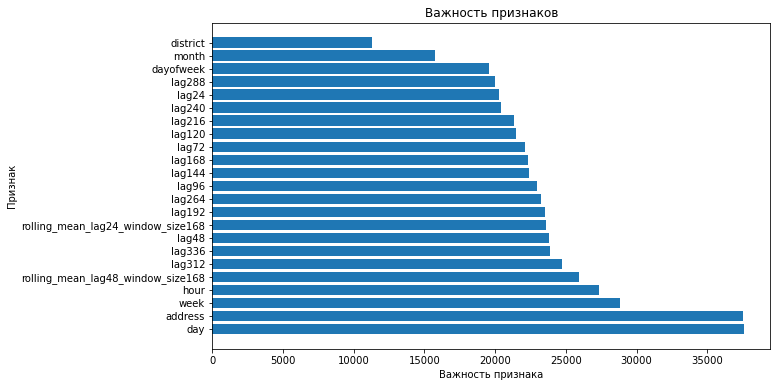

In [64]:
feature_importances = hourly_fcst_address.models_['LGBMRegressor'].feature_importances_
feature_names = hourly_fcst_address.ts.features_order_ 

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Важность признака')
plt.ylabel('Признак')
plt.title('Важность признаков')
plt.show()


In [65]:
predict_address = hourly_fcst_address.predict(24 * 29)

In [66]:
final_val_address = val_transformed.merge(predict_address, on=['point', 'datetime'], how='left')

In [67]:
final_val_address['my_error'] = abs(final_val_address['LGBMRegressor'] - final_val_address['num_publications']) / final_val_address['LGBMRegressor']

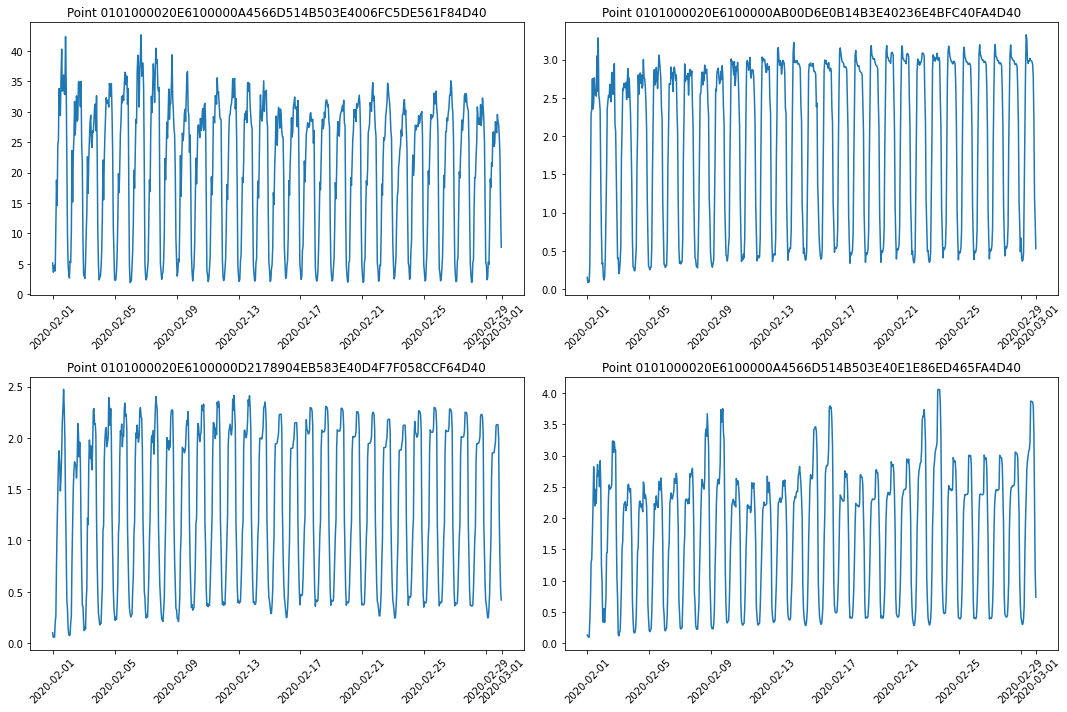

In [68]:
plot_random_time_series(df=final_val_address,
                        predict=predict_address)

In [69]:
final_val_address.describe()

,timestamp,lat,lon,num_publications,error,LGBMRegressor,my_error
count,6.860000e+02,686.000000,686.000000,686.000000,686.000000,686.000000,686.000000
mean,1.581783e+09,59.933357,30.327609,9.848397,2.644801,7.748530,1.180543
std,7.202487e+05,0.041569,0.068056,6.471299,3.868670,7.537689,2.830494
min,1.580548e+09,59.828934,30.142969,5.000000,0.003861,0.270496,0.000062
25%,1.581175e+09,59.921359,30.297929,6.000000,0.467870,3.294695,0.211852
50%,1.581799e+09,59.932612,30.322632,7.000000,1.408210,5.031819,0.478951
75%,1.582408e+09,59.949486,30.356319,11.000000,3.754735,9.583764,1.060004
max,1.583014e+09,60.039332,30.535982,40.000000,38.754735,55.999577,50.335773


Мы заметили, что новая модель демонстрирует немного худшие результаты по сравнению с той, которая не учитывала адреса. Однако стоит отметить, что влияние адресов на прогноз все равно значительно и играет важную роль. 

In [ ]:
predict_address.to_csv('predict_with_address.csv', index=False)

## Final test / Финальное тестирование for LightGBM

In [70]:
test = pd.read_csv('test.csv')
df_predict = pd.read_csv('predict_without_address.csv')

In [71]:
df_predict['datetime'] = pd.to_datetime(df_predict['datetime'])
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4735584 entries, 0 to 4735583
Data columns (total 3 columns):
 #   Column         Dtype         
---  ------         -----         
 0   point          object        
 1   datetime       datetime64[ns]
 2   LGBMRegressor  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 108.4+ MB


In [72]:
test_transformed = test.rename(columns={'sum':'num_publications', 'hour':'timestamp'})
test_transformed['datetime'] = pd.to_datetime(test_transformed['timestamp'], unit='s')

In [73]:
predict_transformed = test_transformed.merge(df_predict, on=['point', 'datetime'], how='left')
predict_transformed['my_error'] = abs(predict_transformed['LGBMRegressor'] - predict_transformed['num_publications']) / predict_transformed['LGBMRegressor']

In [74]:
predict_transformed.describe()

,timestamp,lat,lon,num_publications,error,LGBMRegressor,my_error
count,7.000000e+02,700.000000,700.000000,700.000000,700.000000,700.000000,700.000000
mean,1.581748e+09,59.931030,30.331786,9.682857,2.620662,8.154929,0.842750
std,7.180874e+05,0.040814,0.073457,6.430390,4.055027,7.076530,1.995903
min,1.580537e+09,59.831191,30.142969,5.000000,0.004735,0.575824,0.000141
25%,1.581156e+09,59.921359,30.295683,5.000000,0.421402,3.614913,0.172634
50%,1.581741e+09,59.932612,30.322632,7.000000,1.269158,5.289365,0.431220
75%,1.582391e+09,59.940769,30.358565,11.000000,3.754735,10.380739,0.877328
max,1.583010e+09,60.039332,30.515770,40.000000,38.754735,47.054884,40.880405
